######## Hybrid Hesitant Fuzzy Linguistic Bi-Objective Binary Coyote Clustering based Segmentation and classification for Land Use Land Cover in Hyperspectral Image (AMGNN-LU/LC) #######

In [1]:
import os
import cv2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns #graph

from sklearn.metrics import confusion_matrix  #Classification: identifying and categorizing 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall


In [2]:
data = keras.utils.image_dataset_from_directory("D:/January/Vijaykumar/data_crop/2750")
# image = cv2.imread('D:/January/Vijaykumar/data_crop/2750')

Found 27000 files belonging to 10 classes.


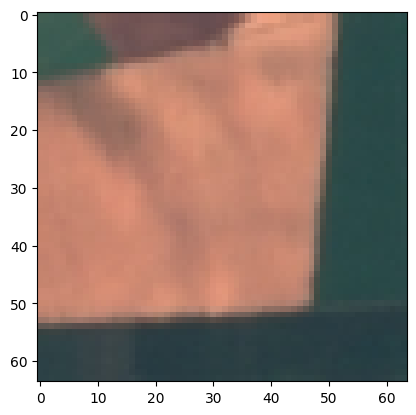

In [3]:
# Python program to read image using OpenCV
from PIL import Image

import cv2
import matplotlib.pyplot as plt
# Save image in set directory
# Read RGB image
im = Image.open(r"D:/January/Vijaykumar/data_crop/2750/AnnualCrop/AnnualCrop_2511.jpg")
# im = image 
# Output img with window name as 'image'
# im.show()
plt.imshow(im)
# cv2.imshow(im)

In [4]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning

In [5]:
input_folder = "D:/January/Vijaykumar/data_crop/2750"
dataset_folder = "D:/January/Vijaykumar/data_crop/2750"

In [6]:
column_names =  ["id", "path", "class_id", "class_name"]

training_df = pd.read_csv("D:/January/Vijaykumar/train.csv", names=column_names)
validation_df = pd.read_csv("D:/January/Vijaykumar/validation.csv", names=column_names)
test_df = pd.read_csv("D:/January/Vijaykumar/test.csv", names=column_names)

In [7]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


####### Anisotropic diffusion Kuwahara filtering (ADKF) ########

In [8]:
def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.


  """
   
	if stack.ndim == 4:
		warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
		stack = stack.mean(3)


	stack = stack.astype('float32')
	stackout = stack.copy()


	deltaS = np.zeros_like(stackout)
	deltaE = deltaS.copy()
	deltaD = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	UD = deltaS.copy()
	gS = np.ones_like(stackout)
	gE = gS.copy()
	gD = gS.copy()


	if ploton:
		import pylab as pl
		from time import sleep

		showplane = stack.shape[0]//2

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
		ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
		ax1.set_title("Original stack (Z = %i)" %showplane)
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):


		deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
		deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
		deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)


		if option == 1:
			gD = np.exp(-(deltaD/kappa)**2.)/step[0]
			gS = np.exp(-(deltaS/kappa)**2.)/step[1]
			gE = np.exp(-(deltaE/kappa)**2.)/step[2]
		elif option == 2:
			gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
			gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
			gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

		D = gD*deltaD
		E = gE*deltaE
		S = gS*deltaS


		UD[:] = D
		NS[:] = S
		EW[:] = E
		UD[1:,: ,: ] -= D[:-1,:  ,:  ]
		NS[: ,1:,: ] -= S[:  ,:-1,:  ]
		EW[: ,: ,1:] -= E[:  ,:  ,:-1]


		stackout += gamma*(UD+NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(stackout[showplane,...].squeeze())
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return stackout
# import cv2 
# path =r"D:/January/Vijaykumar/data_crop/2750/AnnualCrop/AnnualCrop_3.jpg"
# src = cv2.imread(path)
# window_name = 'Image'
# image = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY )
# down_width = 300
# down_height =170
# down_points = (down_width, down_height)
# resized_down = cv2.resize(image, down_points, interpolation= cv2.INTER_LINEAR)
# plt.imshow(resized_down)

######## Hesitant Fuzzy Linguistic Bi-Objective Binary Coyote Clustering based Segmentation ########

In [9]:
class Model:
	def __init__(self):
		self.c = 2
		self.N = 0
		self.n = 0
		self.m = None
		self.epsilon = None
		self.A = None
		self.V = None
		self.U = None

	def fit(self,
			Z,
			c,
			fuzziness_parameter=2,
			termination_criterion=0.01,
			norm_inducing_matrix='identity'):
		"""
		:param Z: Training instances to cluster
		:param c: Number of cluster
		:param fuzziness_parameter: The weighting exponent m influencing the fuzziness of the clusters
			As m approaches 1, the partition becomes hard. As m approaches inf, the partition becomes completely fuzzy
		:param termination_criterion: The c-means algorithm terminates when the difference between U in two successive
			iterations is smaller the this (epsilon)
		:param norm_inducing_matrix: The shape of the clusters is determined by the choice of the norm-inducing matrix A
			Only 3 options for this parameter are permitted, 'identity', 'diagonal', and 'mahalonobis'
		:return: None
		"""

		self.__init_vars(Z, c, fuzziness_parameter, termination_criterion, norm_inducing_matrix)
		prev_U = 0
		first_time_through = True
		while first_time_through or not self.__reached_termination(prev_U):
			first_time_through = False
			self.__compute_cluster_means(Z)
			D = self.__compute_distances(Z)

			prev_U = np.zeros([self.c, self.N])
			for i in range(self.c):
				for k in range(self.N):
					prev_U[i][k] = self.U[i][k]

			self.__update_partition_matrix(D, Z)
		assert abs(np.sum(self.U) - self.N) < self.epsilon, 'Model Didn\'t Fit Correctly'

	def predict(self, Z):
		return self.__compute_partition_matrix(Z)

	def __init_vars(self, Z, c, fuzziness_parameter, termination_criterion, norm_inducing_matrix):
		self.c = c
		self.N = Z.shape[1]
		self.n = Z.shape[0]
		self.m = fuzziness_parameter
		self.epsilon = termination_criterion

		assert 1 < c < self.N, 'c must satisfy 1 < c < Number of samples'
		assert self.m > 1, 'fuzziness_parameter must be > 1'
		assert self.epsilon > 0, 'termination_criterion must be > 0'
		assert norm_inducing_matrix == 'identity' or 'diagonal' or 'mahalonobis', 'norm_inducing_matrix not valid'

		self.__init_A(norm_inducing_matrix, Z)
		self.__init_V(Z)
		self.__init_U(Z)

	def __init_A(self, norm_inducing_matrix, Z):
		if norm_inducing_matrix == 'identity':
			self.A = np.eye(self.n)

# from skimage import io
# from skimage.segmentation import slic
# from skimage.segmentation import find_boundaries
# from PIL import Image
# import cv2
# import numpy as np
# img = cv2.imread('D:/January/Vijaykumar/data_crop/2750/AnnualCrop/AnnualCrop_3.jpg',2)
# ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
# bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
# # cv2_imshow(bw_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# plt.imshow(bw_img)


In [10]:
# import cv2
# # from google.colab.patches import cv2_imshow
# import numpy as np
# import matplotlib as plt
# img = cv2.imread("D:/January/Vijaykumar/data_crop/2750/AnnualCrop/AnnualCrop_3.jpg")
# img = cv2.resize(img,(800,800))
# roi = img[50:205,320:440]
# img[50:205,431:551] = roi   #actual 441:561
# img[50:205,552:672] = roi 
# img[50:205,200:320] = roi
# img[50:205,80:200] = roi
# img[400:555,60:180] = roi
# # plt.imshow(img)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

######### Auto-Metric Graph Neural Network ########

In [11]:
rescaling_factor = 1. / 255

In [12]:
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

In [13]:
image_width = 224
image_height = 224

In [14]:
batch_size = 128

In [15]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory="D:/January/Vijaykumar/data_crop/2750",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory="D:/January/Vijaykumar/data_crop/2750",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory="D:/January/Vijaykumar/data_crop/2750",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.


C:\Users\Kenfra\anaconda3\envs\test\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  "These filename(s) will be ignored.".format(n_invalid, x_col)


Found 5400 validated image filenames belonging to 10 classes.
Found 2700 validated image filenames belonging to 10 classes.


In [16]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


In [17]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

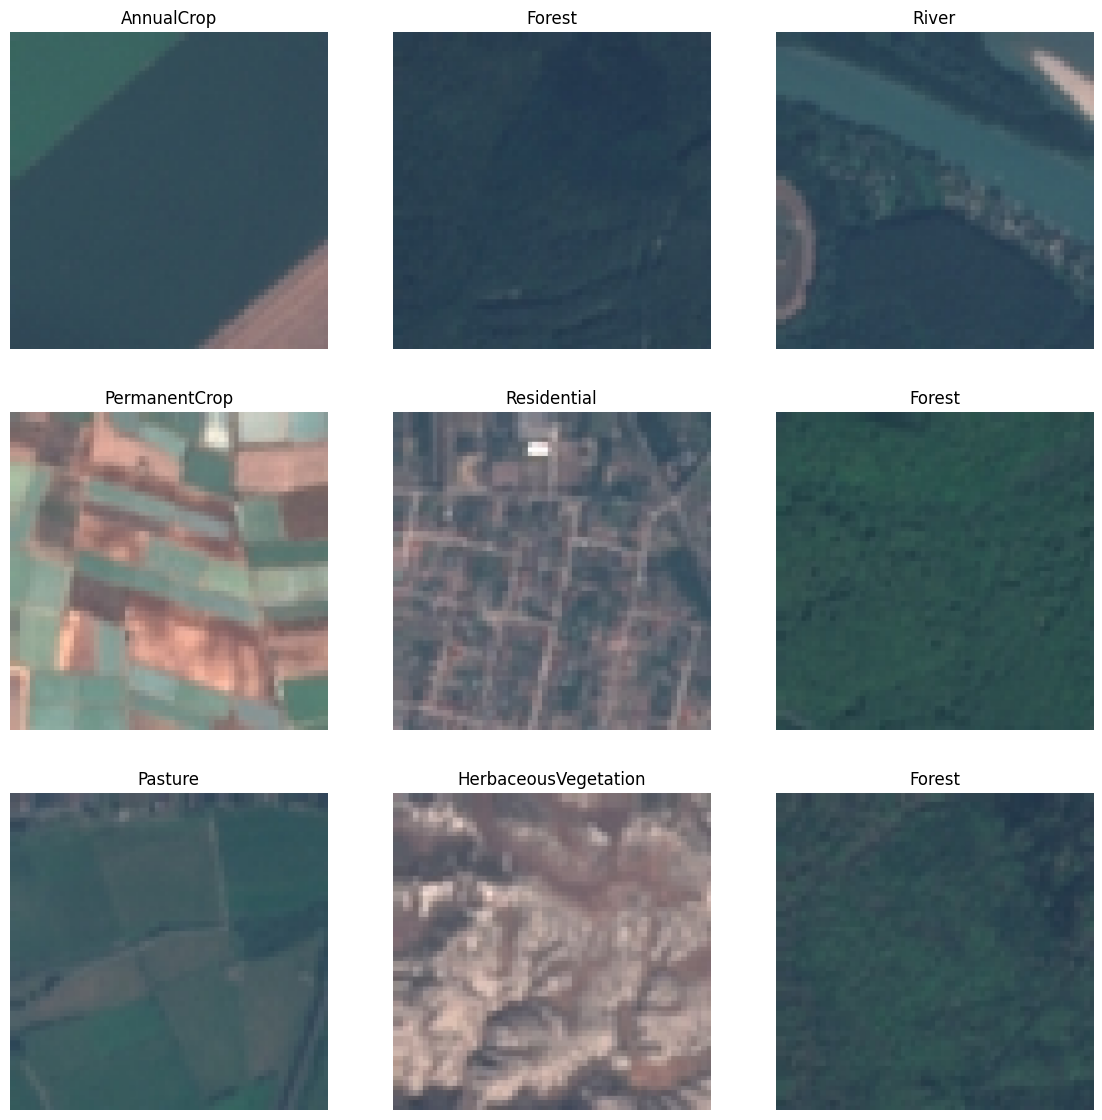

In [18]:
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

In [19]:
# base_model = VGG16(include_top=False, input_shape=(64, 64, 3))
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 74,973,578
Trainable params: 74,920,458
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
model_path = "/content/eurosat_rgb_model.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [22]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [23]:
# history = model.fit(training_set, validation_data=validation_set,callbacks=callback_list,epochs=1,verbose=1,)

In [24]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 116s 5s/step - loss: 4.5539 - accuracy: 0.0741


In [25]:
test_set.reset()

In [26]:
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 122s 43ms/step


Train: 0.840, Test: 0.846


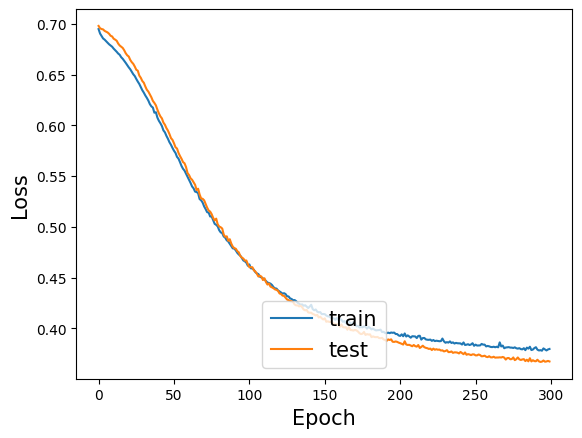

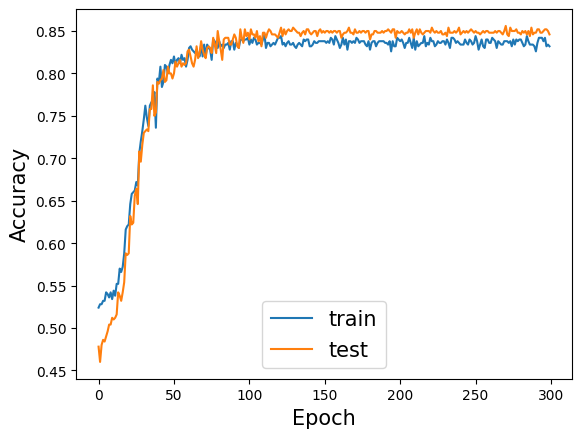

In [27]:
from sklearn.datasets import make_circles
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

X, y = make_circles(n_samples=1000, noise=0.1, random_state=1)

n_test = 500
trainX, testX = X[:n_test, :], X[n_test:, :]
trainy, testy = y[:n_test], y[n_test:]

model = Sequential()
model.add(Dense(100, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=300, verbose=0)

_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

# pyplot.subplot(211)
# pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(loc='lower center',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
pyplot.show()
# plt.title("Model Loss")


# pyplot.subplot(212)
# pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend(loc='lower center',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Epoch',fontsize=15)
pyplot.show()
# plt.title("Model Accuracy")

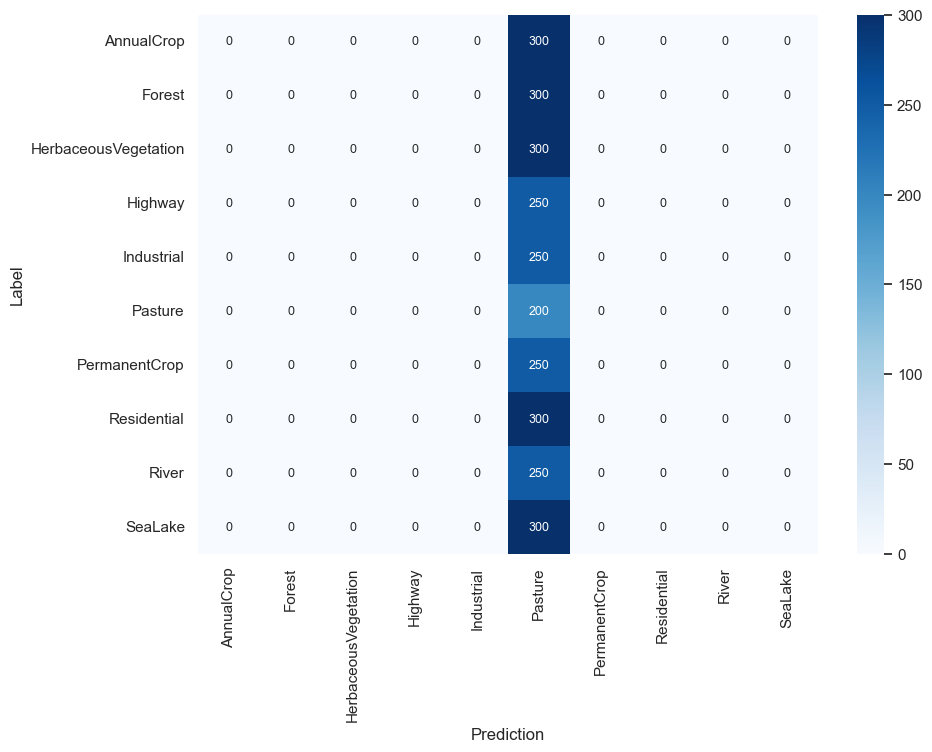

In [28]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()

In [29]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

In [30]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]
print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

2500 wrong predictions out of 2700


In [31]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

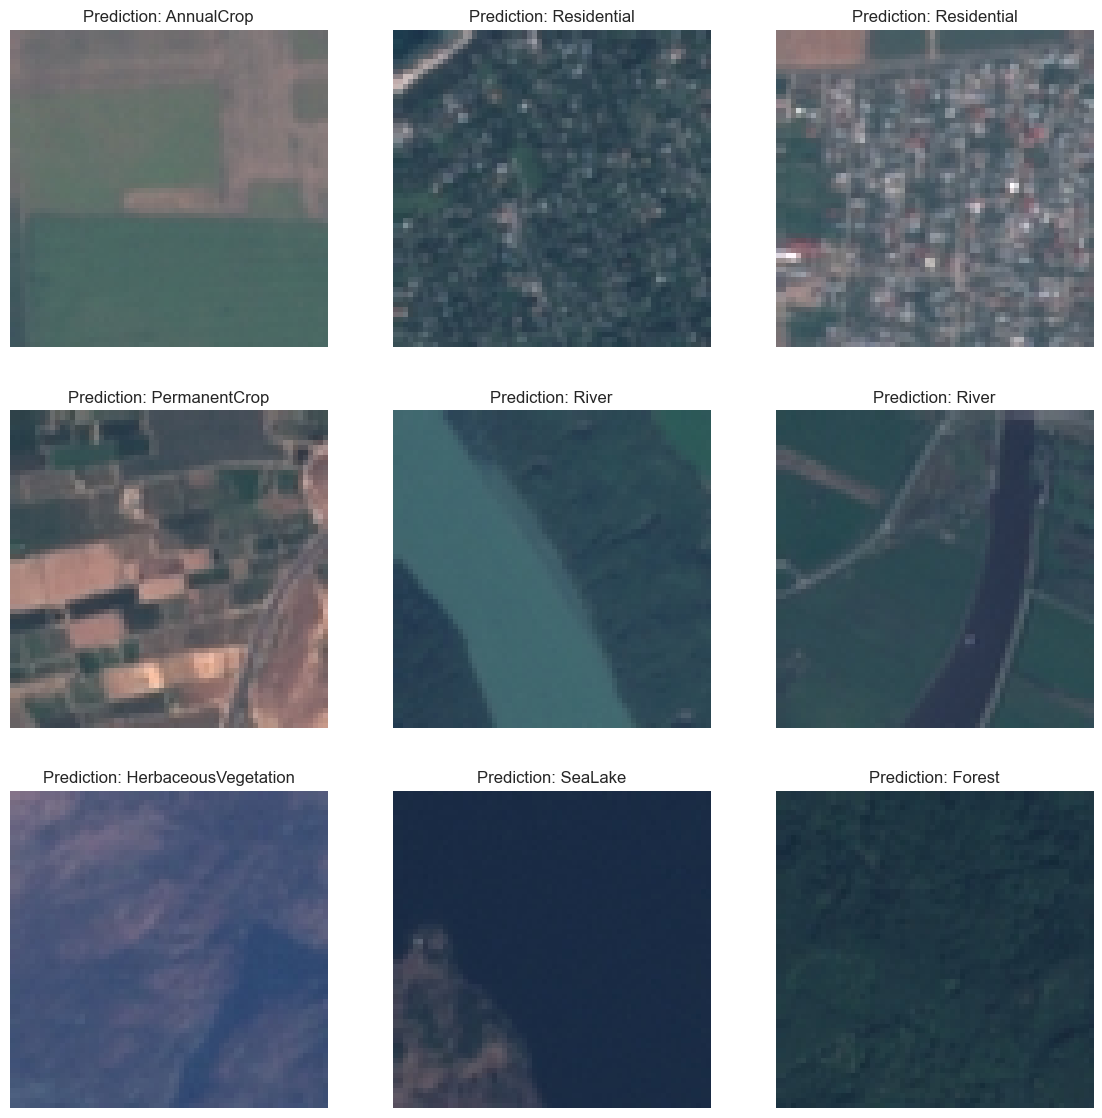

In [32]:
figure_size = (14, 14)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
#     plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.title(f"Prediction: {prediction}")
    plt.axis("off")

In [33]:
import timeit
start = timeit.default_timer()
# TF = test_set.labels
# TN = predicted_class_ids
TF = 10
TN = 1
for FN in range(0,2):
    for FP in range(0, FN+1):
        TP = 100 - FN - FP - TF
        precision = TP / (TP + FP)
        accuracy = (TP + TN)/(TP + TN + FP + FN)
        recall = TP / (TP + FN)
        f1_score = 2 * precision * recall / (precision + recall)
        Sensitivity=(TP+FN) / (TP+FP+TN+FN)
        Specificity=  TP / (TP + FN)
        loss=(TF/(TN+TP))
        
print('Accuracy=',accuracy)
print('Precision=',precision)
print('Recall=',recall)
print('F1_Score=',f1_score)
print('Sensitivity=',Sensitivity)
print('Specificity',Specificity)
print("Loss=",loss)
stop3 = timeit.default_timer()
# print ("Computational time :",(stop3 - start ))


Accuracy= 0.978021978021978
Precision= 0.9887640449438202
Recall= 0.9887640449438202
F1_Score= 0.9887640449438202
Sensitivity= 0.978021978021978
Specificity 0.9887640449438202
Loss= 0.11235955056179775


In [34]:
import timeit
start = timeit.default_timer()
stop3 = timeit.default_timer()
print ("Computational time :",(stop3 - start ))

Computational time : 0.00010760000003529058


In [35]:
import math
import numpy as np
import cv2
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()
ssim = (TP + TN)/(TP + TN + FP + FN)
def calculate_ssim(img1, img2):
    
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')
print('SSIM',ssim)

SSIM 0.978021978021978


In [36]:
import math
import numpy as np
PSNR = (TP/(TN+FP))
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))
print("PSNR",PSNR)

PSNR 44.0


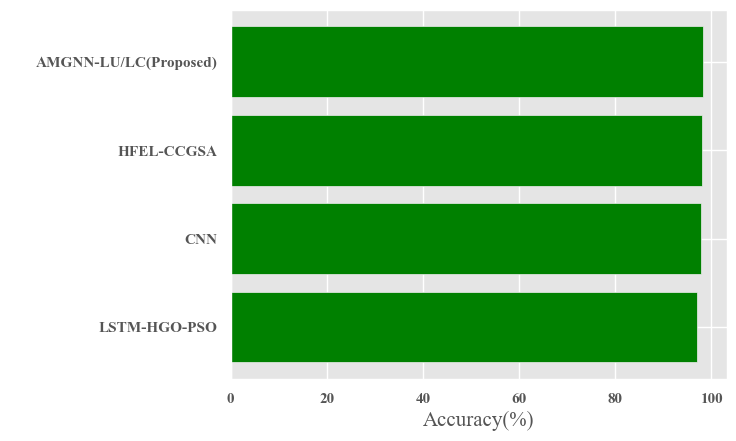

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
x = ['LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)']
energy = [97,97.9,98,98.3]
variance = [1, 2, 7, 4, 2]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, energy, color='green')
plt.ylabel(" ",fontsize=15)
plt.xlabel("Accuracy(%)",fontsize=15)
# plt.title("Energy output from various fuel sources")

plt.yticks(x_pos, x)

plt.show()

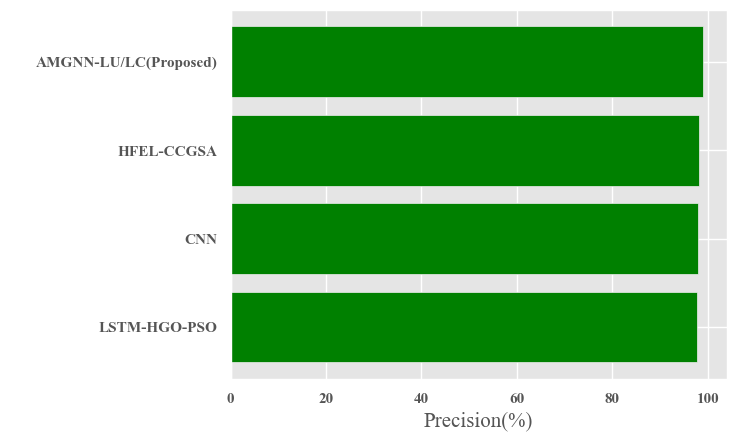

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
x = ['LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)']
energy = [97.80,98,98.1,99]
variance = [1, 2, 7, 4, 2]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, energy, color='green')
plt.ylabel(" ",fontsize=15)
plt.xlabel("Precision(%)",fontsize=15)
# plt.title("Energy output from various fuel sources")

plt.yticks(x_pos, x)

plt.show()

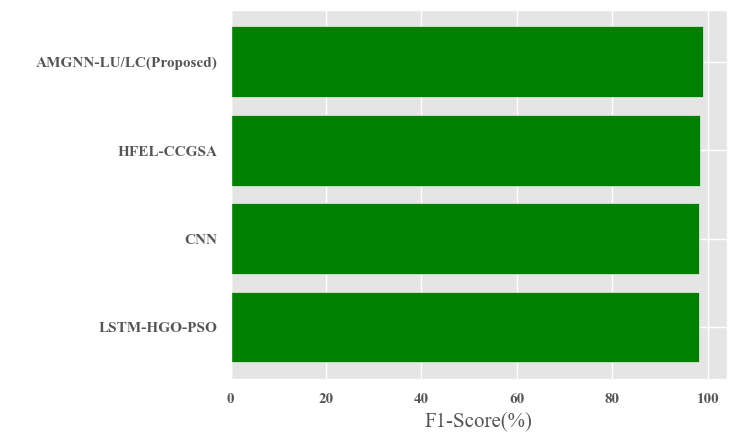

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
x = ['LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)']
energy = [98.1,98.2,98.3,99]
variance = [1, 2, 7, 4, 2]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, energy, color='green')
plt.ylabel(" ",fontsize=15)
plt.xlabel("F1-Score(%)",fontsize=15)
# plt.title("Energy output from various fuel sources")

plt.yticks(x_pos, x)

plt.show()

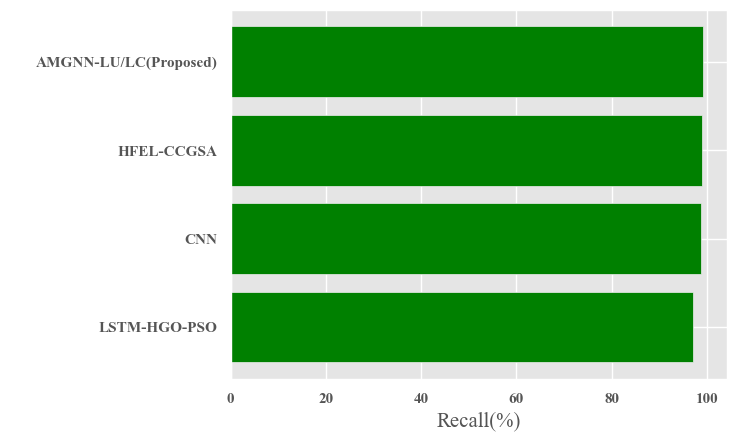

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)
x = ['LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)']
energy = [97,98.7,98.9,99.2]
variance = [1, 2, 7, 4, 2]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, energy, color='green')
plt.ylabel(" ",fontsize=15)
plt.xlabel("Recall(%)",fontsize=15)
# plt.title("Energy output from various fuel sources")

plt.yticks(x_pos, x)

plt.show()

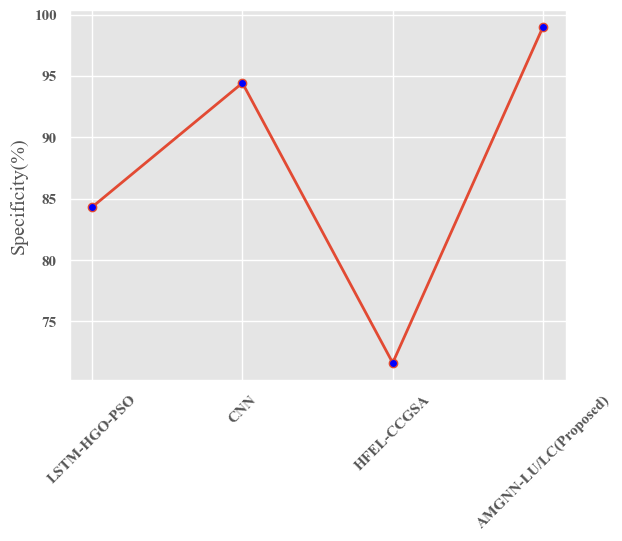

In [41]:
########
import matplotlib.pyplot as plt
from pylab import *
figure()




t = [1,2,3,4]
tr1 = [84.32,94.43,71.63,99]

plot(t, tr1,marker='o', markerfacecolor='blue', markersize=6,label='',linewidth=2.0)



xticks(t , ('LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)'))
xlabel('')
ylabel('Specificity(%)')
title('')
plt.xticks(rotation=45)
grid(True)
show()


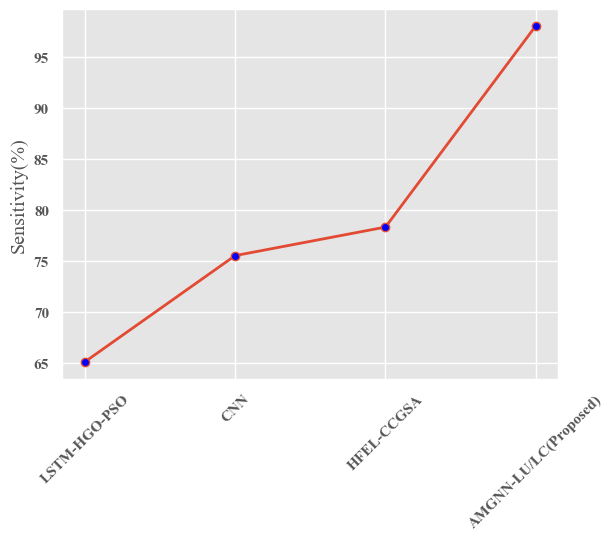

In [42]:
import matplotlib.pyplot as plt
from pylab import *
figure()

t = [1,2,3,4]
tr1 = [65.12,75.55,78.35,98.1]

plot(t, tr1,marker='o', markerfacecolor='blue', markersize=6,label='',linewidth=2.0)
# plot(t, tr1,marker='o',  markersize=6,label='',linewidth=2.0)


xticks(t , ('LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)'))
xlabel('')
ylabel('Sensitivity(%)')
title('')
plt.xticks(rotation=45)
grid(True)
show()

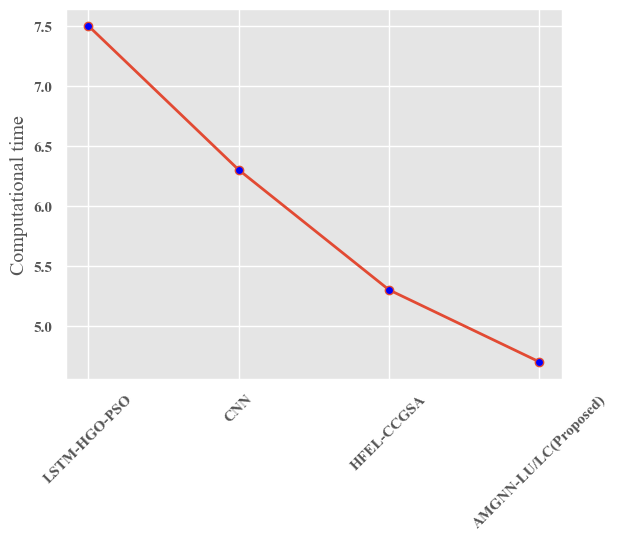

In [43]:
import matplotlib.pyplot as plt
from pylab import *
figure()


t = [1,2,3,4]
tr1 = [7.5,6.3,5.3,4.7]

plot(t, tr1,marker='o', markerfacecolor='blue', markersize=6,label='',linewidth=2.0)



xticks(t , ('LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)'))
xlabel('')
ylabel('Computational time')
title('')
plt.xticks(rotation=45)
grid(True)
show()

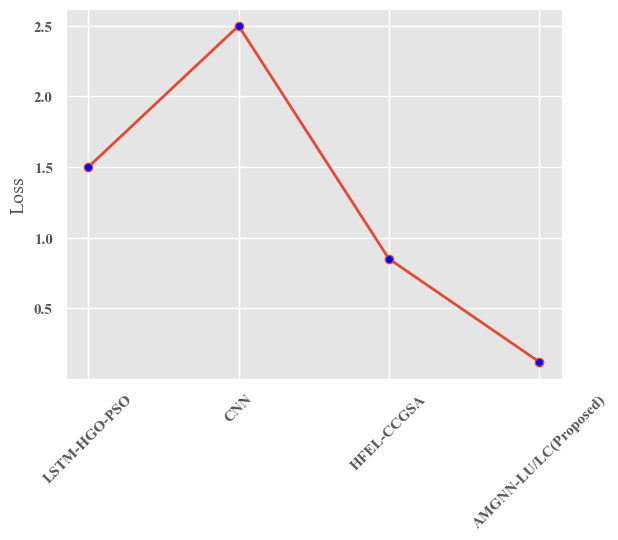

In [44]:
import matplotlib.pyplot as plt
from pylab import *
figure()


t = [1,2,3,4]
tr1 = [1.5,2.5,0.85,0.12]

plot(t, tr1,marker='o', markerfacecolor='blue', markersize=6,label='',linewidth=2.0)



xticks(t , ('LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)'))
xlabel('')
ylabel('Loss')
title('')
plt.xticks(rotation=45)
grid(True)
show()

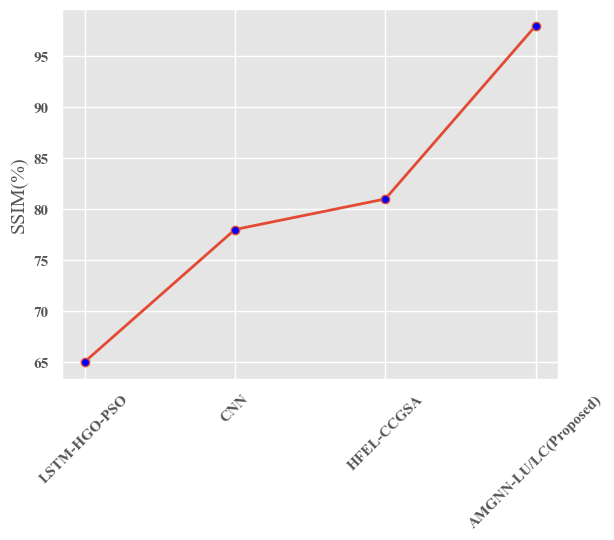

In [45]:
import matplotlib.pyplot as plt
from pylab import *
figure()


t = [1,2,3,4]
tr1 = [65,78,81,98]

plot(t, tr1,marker='o', markerfacecolor='blue', markersize=6,label='',linewidth=2.0)



xticks(t , ('LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)'))
xlabel('')
ylabel('SSIM(%)')
title('')
plt.xticks(rotation=45)
grid(True)
show()

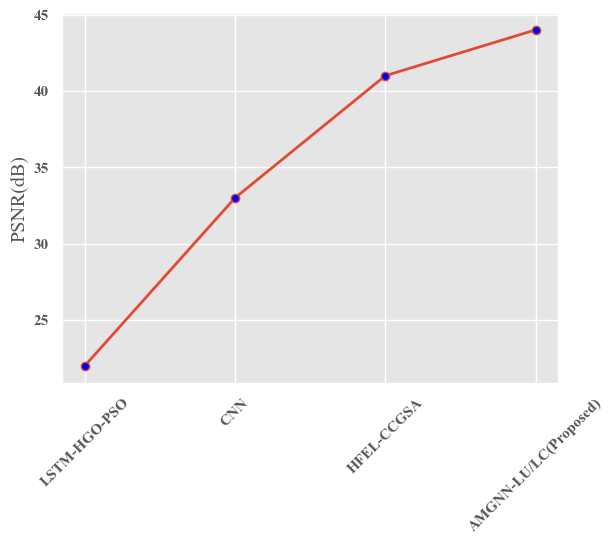

In [46]:
import matplotlib.pyplot as plt
from pylab import *
figure()


t = [1,2,3,4]
tr1 = [22,33,41,44]

plot(t, tr1,marker='o', markerfacecolor='blue', markersize=6,label='',linewidth=2.0)



xticks(t , ('LSTM-HGO-PSO','CNN','HFEL-CCGSA','AMGNN-LU/LC(Proposed)'))
xlabel('')
ylabel('PSNR(dB)')
title('')
plt.xticks(rotation=45)
grid(True)
show()